获取工作路径

In [4]:
import os
print(os.getcwd())

C:\Users\chenj\Documents\GitHub\ultralytics


In [25]:
import os
import albumentations as A
import numpy as np
import shutil
import random

# 输入输出路径
input_dir = 'C:/Users/chenj/Documents/GitHub/ultralytics/ultralytics/datasets'
output_dir = 'C:/Users/chenj/Documents/GitHub/ultralytics/ultralytics/Traindatasets-test'

# 创建数据增强方法
transform = A.Compose([
    A.GaussianBlur(p=0.3),    # 模糊
    A.RandomBrightnessContrast(p=0.2),  # 随机亮度和对比度
    A.MotionBlur(blur_limit=5, p=0.2),  # 运动模糊
    A.ImageCompression(quality_lower=70, p=0.3),  # 图像压缩模拟拍摄质量降低
    A.CLAHE(p=0.2),  # 对比度增强
    A.ToGray(p=1.0),  # 灰度化
    A.Perspective(scale=(0.02, 0.05), p=0.3),  # 使用 Perspective 进行仿射变换
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# 添加背景干扰
def add_background_noise(image):
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    return cv2.add(image, noise)

# 计算 OBB 格式的角点坐标
def calculate_obb_corners(x_center, y_center, width, height, angle, w, h):
    # 将 YOLO 坐标转换为像素坐标
    x_center, y_center = x_center * w, y_center * h
    width, height = width * w, height * h

    # 计算旋转前的四个角点
    corners = np.array([
        [x_center - width / 2, y_center - height / 2],
        [x_center + width / 2, y_center - height / 2],
        [x_center + width / 2, y_center + height / 2],
        [x_center - width / 2, y_center + height / 2]
    ])

    # 使用与图像相同的旋转矩阵
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)

    # 应用旋转矩阵
    ones = np.ones(shape=(len(corners), 1))
    corners_ones = np.hstack([corners, ones])
    rotated_corners = M.dot(corners_ones.T).T

    # 将角点归一化到 0 到 1 范围
    normalized_corners = rotated_corners / np.array([w, h])
    return normalized_corners

# 旋转图像和边界框并转换为 OBB 格式
def rotate_image_and_bbox_to_obb(image, bboxes, angle):
    h, w = image.shape[:2]

    # 旋转图像
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h))

    rotated_bboxes = []
    for bbox in bboxes:
        x_center, y_center, bbox_width, bbox_height = bbox
        corners = calculate_obb_corners(x_center, y_center, bbox_width, bbox_height, angle, w, h)
        rotated_bboxes.append(corners.flatten())

    return rotated_image, rotated_bboxes

# 保存图像和标签
def save_image_and_label(image, bboxes, image_output_path, label_output_path, class_labels):
    cv2.imwrite(image_output_path, image)
    with open(label_output_path, 'w') as f:
        for corners, class_id in zip(bboxes, class_labels):
            label = [class_id] + corners.tolist()
            f.write(' '.join(map(str, label)) + '\n')

# 处理单个图像文件夹（如训练或验证集）
def process_image_folder(image_dir, label_dir, output_image_dir, output_label_dir, augment=True):
    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        if image is None:
            print(f"无法读取图像: {image_path}")
            continue

        height, width, _ = image.shape

        # 读取 YOLO 格式标签
        bboxes, class_labels = [], []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
                bboxes.append([x_center, y_center, bbox_width, bbox_height])
                class_labels.append(int(class_id))

        # 生成增强样本
        num_augmentations = 10 if augment else 1
        for i in range(num_augmentations):
            processed_image = add_background_noise(image) if augment else image.copy()
            rotate_angle = random.uniform(-20, 20) if augment else random.uniform(-10, 10)

            # 数据增强
            if augment:
                transformed = transform(image=processed_image, bboxes=bboxes, class_labels=class_labels)
                processed_image, transformed_bboxes = transformed['image'], transformed['bboxes']
            else:
                transformed_bboxes = bboxes

            # 旋转并转换标签为 OBB 格式
            rotated_image, rotated_bboxes = rotate_image_and_bbox_to_obb(processed_image, transformed_bboxes, rotate_angle)

            # 保存增强后的图像和 OBB 标签
            output_image_name = f"{image_name.replace('.jpg', '')}_aug_{i}.jpg"
            output_label_name = output_image_name.replace('.jpg', '.txt')
            save_image_and_label(rotated_image, rotated_bboxes,
                                 os.path.join(output_image_dir, output_image_name),
                                 os.path.join(output_label_dir, output_label_name),
                                 class_labels)

# 创建增强后的数据集文件夹结构
def setup_output_dirs():
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    for split in ['train', 'val']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

# 主函数
def main():
    setup_output_dirs()
    # 处理训练集
    process_image_folder(
        image_dir=os.path.join(input_dir, 'images', 'train'),
        label_dir=os.path.join(input_dir, 'labels', 'train'),
        output_image_dir=os.path.join(output_dir, 'images', 'train'),
        output_label_dir=os.path.join(output_dir, 'labels', 'train'),
        augment=True
    )
    # 处理验证集（不增强，仅旋转转换标签）
    process_image_folder(
        image_dir=os.path.join(input_dir, 'images', 'val'),
        label_dir=os.path.join(input_dir, 'labels', 'val'),
        output_image_dir=os.path.join(output_dir, 'images', 'val'),
        output_label_dir=os.path.join(output_dir, 'labels', 'val'),
        augment=False
    )
    print("训练和验证数据集的增强与转换已完成，结果保存到:", output_dir)

# 执行主函数
main()


训练和验证数据集的增强与转换已完成，结果保存到: C:/Users/chenj/Documents/GitHub/ultralytics/ultralytics/Traindatasets-test


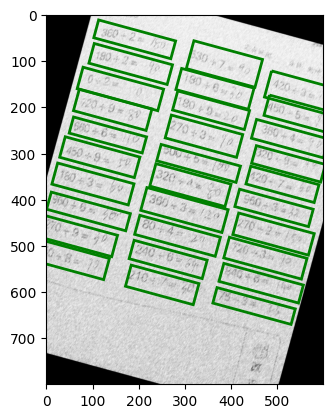

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def read_bboxes_from_txt(label_path):
    """
    从文本文件中读取标注框
    :param label_path: 标签文件路径
    :return: 标注框列表，每个标注框包含四个角点的坐标（归一化到0-1范围）
    """
    bboxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = list(map(float, line.strip().split()))
            class_id = int(parts[0])
            corners = parts[1:]
            bboxes.append(corners)
    return bboxes

def visualize_bboxes(image_path, bboxes):
    """
    可视化四角点标注框
    :param image_path: 图像文件路径
    :param bboxes: 标注框列表，每个标注框包含四个角点的坐标
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图像: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in bboxes:
        corners = np.array(bbox).reshape(4, 2) * np.array([image.shape[1], image.shape[0]])
        polygon = patches.Polygon(corners, closed=True, edgecolor='g', linewidth=2, fill=False)
        ax.add_patch(polygon)

    plt.show()

# 示例使用
image_path = 'C:/Users/chenj/Documents/GitHub/ultralytics/ultralytics/TrainDatasets/images/train/149_aug_1.jpg'
label_path = 'C:/Users/chenj/Documents/GitHub/ultralytics/ultralytics/TrainDatasets/labels/train/149_aug_1.txt'

# 从标签文件中读取标注框
bboxes = read_bboxes_from_txt(label_path)

# 可视化标注框
visualize_bboxes(image_path, bboxes)



# 示例使用


